In [57]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls drive/MyDrive/NN_MEFs/

CAISO_Data_2019_2021_NN_Ts.csv	FF_models  FF_NN_MEFs.ipynb


## Parameters

In [4]:
work_dir = "drive/MyDrive/NN_MEFs"
data_file = f"{work_dir}/CAISO_Data_2019_2021_NN_Ts.csv"
model_save_dir = f"{work_dir}/FF_models"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## data exploration

In [5]:
data_df = pd.read_csv(data_file)

In [6]:
data_df.head()

,Unnamed: 0,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,...,Hour,Month,Day,Pas_Temp,SJ_Temp,NH_Temp,SB_Temp,Sac_Temp,Fres_Temp,LB_Temp
0,2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,...,0,1,1,49.2,33.6,50.7,46.3,33.9,54.9,54.9
1,2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,...,1,1,1,42.7,30.7,49.8,45.6,34.1,54.0,54.0
2,2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,...,2,1,1,40.4,30.1,50.3,45.1,32.7,52.8,52.8
3,2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,...,3,1,1,39.2,29.1,47.2,44.4,32.1,52.6,52.6
4,2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,...,4,1,1,37.6,28.4,42.5,44.3,31.4,52.0,52.0


## Data Loading and pre-processing

In [7]:
# read in the processed data. there should be zero nans or missing data.
CAISO_Data = pd.read_csv(data_file, index_col=0)
CAISO_Data.index = pd.to_datetime(CAISO_Data.index)
num_samples = len(CAISO_Data)

# TODO: possibly play with temporal features here (i.e. make them non-categorical)
CAISO_Data.loc[:,"Day_of_Year"] = [instant.timetuple().tm_yday for instant in CAISO_Data.index]
CAISO_Data.loc[:,"Is_Weekend"] = [instant.weekday() > 4 for instant in CAISO_Data.index]
for day_of_week in range(7):
    CAISO_Data.loc[:,f"Day_of_Week={day_of_week}"] = [instant.weekday() ==day_of_week for instant in CAISO_Data.index]

# create masks for train, validation and test data
percent_train, percent_val, percent_test = .6, .2, .2
num_train, num_val = int(percent_train * num_samples), int(percent_val * num_samples)
num_test = num_samples - num_train - num_val
set_assignments = np.array([1 for i in range(num_train)] + [2 for i in range(num_val)] + [3 for i in range(num_test)])
np.random.seed(1)
np.random.shuffle(set_assignments)
train_mask = set_assignments == 1
val_mask = set_assignments == 2
test_mask = set_assignments == 3
CAISO_train = CAISO_Data.loc[train_mask]
CAISO_val = CAISO_Data.loc[val_mask]
CAISO_test = CAISO_Data.loc[test_mask]

# Old features include different temporal features
# feature_cols = ['Load', 'VRE', 'Hour', 'Month', 'Day', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# This works similarly... actually maybe slightly worse? Hard to say. Let's add 1-hot encodded day of the week instead of is_weekend.
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Is_Weekend', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# Can add these... Let's try without for now.
# feature_cols.extend([f"Day_of_Week={day_of_week}" for day_of_week in range(7)])
# now we will try dropping the temperatures
feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year']



# specify x and y data #TODO seems like there may be some unnecessary operations here... 
train_x = torch.tensor(CAISO_train[feature_cols].values.astype(np.float32))
train_y = torch.tensor(np.array(CAISO_train['delta_Total_CO2_Emissions'].values).astype(np.float32))
val_x = torch.tensor(CAISO_val[feature_cols].values.astype(np.float32))
val_y = torch.tensor(np.array(CAISO_val['delta_Total_CO2_Emissions'].values).astype(np.float32))
test_x = torch.tensor(CAISO_test[feature_cols].values.astype(np.float32))
test_y = torch.tensor(np.array(CAISO_test['delta_Total_CO2_Emissions'].values).astype(np.float32))

# standardize data based on mean and variance of train data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x)
train_x = torch.tensor(scaler.transform(train_x)).to(device)
val_x = torch.tensor(scaler.transform(val_x)).to(device)
test_x = torch.tensor(scaler.transform(test_x)).to(device)



## define model and set params

In [17]:
n_input = len(feature_cols)
n_out = 3    # 3 output parameters: MEF, MDF, interecept. 
             # inclusion of intercept is debatable (we'd love to have a model where it is zero),
             # and so far it has not much impacted r^2.
             # once we do test train split i only want to keep it if it notably improves model accuracy

            
def get_model(n_input, hidden_dims, n_out, dropout_p):
    
    layers = [nn.Linear(n_input, hidden_dims[0]),
              nn.BatchNorm1d(hidden_dims[0]),
              nn.ReLU(),
              nn.Dropout(dropout_p)
             ]
    for layer in range(len(hidden_dims)-1):
        cur_hidden, next_hidden = hidden_dims[layer], hidden_dims[layer+1]
        layers.extend([nn.Linear(cur_hidden, next_hidden),
                       nn.BatchNorm1d(next_hidden),
                       nn.ReLU(),
                       nn.Dropout(dropout_p)
                      ])
    layers.append(nn.Linear(hidden_dims[-1], n_out))
    
    model = nn.Sequential(*layers)
    return model

# Stepp: gotta start with tensors and use torch math functions to keep as tensors
# def mse_loss(pred_coeff, CAISO_Data):
#     delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
#     delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
#     MEF_preds = pred_coeff[:,0]
#     MDF_preds = pred_coeff[:,1]
#     pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
#     pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
#     pred_y = torch.add(pred_y_vre, pred_y_demand)
#     act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))
#     loss = nn.MSELoss()(pred_y, act_y)
#     return loss

def mse_loss_regularized_preds_l2(pred_coeff, CAISO_Data, MEF_reg_weight, MDF_reg_weight, bias_term):
    delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
    delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
    MEF_preds = pred_coeff[:,0]
    MDF_preds = pred_coeff[:,1]
    pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
    pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
    pred_y = pred_y_vre + pred_y_demand
    if bias_term:
        bias_preds = pred_coeff[:,2]
        pred_y += bias_preds
    act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))

    # Compute MEF regularization term (sum(MEF^2 + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 4420  # based on an average value of -65 seen amongst invalids when trained without regularization
    MEF_reg = torch.dot(invalid_MEFs, invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF^2 + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 538  # based on an average value of +23 seen amongst invalids when trained without regularization
    MDF_reg = torch.dot(invalid_MDFs, invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(pred_y, act_y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

def mse_loss_regularized_preds_l1(pred_coeff, CAISO_Data, MEF_reg_weight, MDF_reg_weight, bias_term):
    delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
    delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
    MEF_preds = pred_coeff[:,0]
    MDF_preds = pred_coeff[:,1]
    pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
    pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
    pred_y = pred_y_vre + pred_y_demand
    if bias_term:
        bias_preds = pred_coeff[:,2]
        pred_y += bias_preds
    act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))

    # Compute MEF regularization term (sum(MEF + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 66.5  # The average value seen amongst invalids when trained without regularization
    MEF_reg = torch.sum(invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 23.2  # The average value seen amongst invalids when trained without regularization
    MDF_reg = torch.sum(invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(pred_y, act_y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

## Model Training

Helpers for printing results

In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

In [58]:
def print_results(train_losses, train_pred_coeff, train_CAISO_Data, val_losses, val_pred_coeff, val_CAISO_Data, bias_term):
    #plot loss vs epochs
    plt.subplot(1, 2, 1)
    plt.plot(train_losses[1000:])
    plt.title("Train Set")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_losses[1000:])
    plt.title("Val Set")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    plt.tight_layout()
    plt.show()

    # count number of invalid values predicted
    invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
    invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)

    #add MEF, MDF and interecept results to orignial frame #TODO once again seems like more operations than necessary
    coeff_df=pd.DataFrame(data=train_pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    train_CAISO_Data.loc[:,'MEF']=coeff_df.loc[:,'MEF'].values
    train_CAISO_Data.loc[:,'MDF']=coeff_df.loc[:,'MDF'].values
    if bias_term:
        train_CAISO_Data.loc[:,'Intercept']=coeff_df.loc[:,'Intercept'].values

    #calculate some error stuff. rn i am thinking R2 is the best measure of error
    d_emissions = train_CAISO_Data.loc[:,'MEF'] * train_CAISO_Data.loc[:,'delta_Load'] \
                + train_CAISO_Data.loc[:,'MDF'] * train_CAISO_Data.loc[:,'delta_VRE']
    if bias_term:
        d_emissions += train_CAISO_Data.loc[:,'Intercept'] 
    train_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
    train_CAISO_Data.loc[:,'Error']=train_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-train_CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
    train_CAISO_Data.loc[:,'%_Error']=np.abs(train_CAISO_Data.loc[:,'Error'])/np.abs(train_CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
    print("Train Set:")
    print(f"\tMean Emissions Change = {np.mean(np.abs(train_CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
    print(f"\tMean Error = {np.mean(np.abs(train_CAISO_Data['Error'])):.2f}")
    print(f"\tInvalid MEFs,MDFs = {invalid_train_MEFs},{invalid_train_MDFs}")
    print(f"\tR Squared = {r2_score(train_CAISO_Data['delta_Total_CO2_Emissions'],train_CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
    
    #TODO make this better so we don't have copy pasta
    #add MEF, MDF and interecept results to orignial frame #TODO once again seems like more operations than necessary
    coeff_df=pd.DataFrame(data=val_pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    val_CAISO_Data.loc[:,'MEF']=coeff_df.loc[:,'MEF'].values
    val_CAISO_Data.loc[:,'MDF']=coeff_df.loc[:,'MDF'].values
    if bias_term:
        val_CAISO_Data.loc[:,'Intercept']=coeff_df.loc[:,'Intercept'].values

    #calculate some error stuff. rn i am thinking R2 is the best measure of error
    d_emissions = val_CAISO_Data.loc[:,'MEF'] * val_CAISO_Data.loc[:,'delta_Load'] \
                + val_CAISO_Data.loc[:,'MDF']*val_CAISO_Data.loc[:,'delta_VRE']
    if bias_term:
        d_emissions += val_CAISO_Data.loc[:,'Intercept'] 
    val_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
    val_CAISO_Data.loc[:,'Error']=val_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-val_CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
    val_CAISO_Data.loc[:,'%_Error']=np.abs(val_CAISO_Data.loc[:,'Error'])/np.abs(val_CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
    print("Val Set:")
    print(f"\tMean Emissions Change = {np.mean(np.abs(val_CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
    print(f"\tMean Error = {np.mean(np.abs(val_CAISO_Data['Error'])):.2f}")
    print(f"\tInvalid MEFs,MDFs = {invalid_val_MEFs},{invalid_val_MDFs}")
    print(f"\tR Squared = {r2_score(val_CAISO_Data['delta_Total_CO2_Emissions'],val_CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
    
def get_r_squared(pred_coeff, CAISO_Data, bias_term):
    coeff_df=pd.DataFrame(data=pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    pred_delta_total_co2_emissions = coeff_df['MEF'].values * CAISO_Data['delta_Load'] \
                                   + coeff_df['MDF'].values * CAISO_Data['delta_VRE']
    if bias_term:
        pred_delta_total_co2_emissions += coeff_df['Intercept'].values
    r2 = r2_score(CAISO_Data['delta_Total_CO2_Emissions'], pred_delta_total_co2_emissions)
    return r2

def get_mean_abs_err(pred_coeff, CAISO_Data, bias_term):
    coeff_df=pd.DataFrame(data=pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    pred_delta_total_co2_emissions = coeff_df['MEF'].values * CAISO_Data['delta_Load'] \
                                   + coeff_df['MDF'].values * CAISO_Data['delta_VRE']
    if bias_term:
        pred_delta_total_co2_emissions += coeff_df['Intercept'].values
    mean_abs_err = mean_absolute_error(CAISO_Data['delta_Total_CO2_Emissions'], pred_delta_total_co2_emissions)
    return mean_abs_err

def get_count_invalid_preds(pred_coeff):
    # preds=pred_coeff.detach().numpy()
    count_neg_MEFs = torch.sum(pred_coeff[:,0] <= 0).item() #sum(preds[:,0] <= 0) # MEF must be greater than 0
    count_pos_MDFs = torch.sum(pred_coeff[:,1] > 0).item() #sum(preds[:,1] > 0)  # MDF must be less than or equal to 0
    return count_neg_MEFs, count_pos_MDFs

Train the model

In [26]:
def train_model_with_params(hidden_dims, learning_rate, weight_decay, dropout_p, CAISO_Data, \
                            loss_function, MEF_reg_weight, MDF_reg_weight, bias_term, model_dir_prefix=None, epochs=10000):
    
    print(f"Model Params: hidden_dims={','.join(str(dim) for dim in hidden_dims)}, learning_rate={learning_rate}, weight_decay={weight_decay}, dropout={dropout_p}" \
          + f", loss_function={loss_function}, MEF_reg_weight={MEF_reg_weight}, MDF_reg_weight={MDF_reg_weight}, bias={bias_term}")
    model = get_model(n_input, hidden_dims, n_out, dropout_p)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model_dir = model_save_dir
    if model_dir_prefix:
        model_dir += f"/{model_dir_prefix}"
    model_dir += f"/hidden={','.join(str(dim) for dim in hidden_dims)}," \
              + f"LR={learning_rate},w_decay={weight_decay},dropout={dropout_p},MEF_reg={MEF_reg_weight},MDF_reg={MDF_reg_weight},bias={bias_term}"
    
    Path(model_dir).mkdir(parents=True, exist_ok=True)

    with open(f"{model_dir}/features.txt", 'w+') as f:
        f.write(", ".join(feature_cols))

    model.to(device)

    min_save_r2 = .87 # Don't save model unless gets above .87 as we know we can do this well.
    best_r2 = -np.inf 
    best_epoch = None
    save_model_path = None
    last_save_epoch = None
    last_save_r2 = -np.inf
    
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        # tell model we are training (for bathnorm layer, dropout...)
        model.train()
        train_pred_coeff=model(train_x.float()).cpu()
        train_loss=loss_function(train_pred_coeff, CAISO_train, MEF_reg_weight, MDF_reg_weight, bias_term)
        train_losses.append(train_loss.item())
        
        # tell model we are evaluating
        model.eval()
        val_pred_coeff=model(val_x.float()).cpu()
        val_loss=loss_function(val_pred_coeff, CAISO_val, MEF_reg_weight, MDF_reg_weight, bias_term)
        val_losses.append(val_loss.item())
        val_r2 = get_r_squared(val_pred_coeff, CAISO_val, bias_term)

        # always keep best r2 updated
        if val_r2 > best_r2:
            best_r2 = val_r2
            best_epoch = epoch
        # check if we should save... we need good enough r2 and no invalids
        if val_r2 > max(last_save_r2, min_save_r2):
            if sum(get_count_invalid_preds(val_pred_coeff))==0:
                # also check training invalids... Let's recompute with eval mode
                model.eval()
                eval_mode_train_preds=model(train_x.float()).cpu()
                if sum(get_count_invalid_preds(eval_mode_train_preds))==0:
                    if save_model_path:
                        Path(save_model_path).unlink() # delete prev-best model
                    model_save_name = f"epoch={epoch},r2={val_r2:.4f},Invalids=0.pth"
                    save_model_path = f"{model_dir}/{model_save_name}"
                    torch.save(model.state_dict(), save_model_path)
                    last_save_epoch = epoch
                    last_save_r2 = val_r2

        
        if epoch % 1000 == 0:
            invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
            invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
            train_r2 = get_r_squared(train_pred_coeff, CAISO_train, bias_term)
            # val_r2 = get_r_squared(val_pred_coeff, CAISO_val, bias_term)
            print(f"[Epoch {epoch}]")
            print(f"\tTrain Set: Loss={train_loss.item():.3e}, R Squared={train_r2:.4f}, Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
            print(f"\tVal Set: Loss={val_loss.item():.3e}, R Squared={val_r2:.4f}, Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")
        model.zero_grad()
        train_loss.backward()
        optimizer.step()
        # stop if we aren't improving after 10k epochs
        if best_epoch and epoch > 10000 + best_epoch:
            print("Early stopping as we haven't made an improvement on validation set in 10,000 epochs.")
            break

    print_results(train_losses, train_pred_coeff, CAISO_train, val_losses, val_pred_coeff, CAISO_val, bias_term)
    print(f"best R Squared seen on epoch {best_epoch}: {best_r2:.4f}")
    if save_model_path:
        print(f"best R Squared with no invalids predicted in train/val seen on epoch {last_save_epoch}: {last_save_r2:.4f}")
    else:
        print(f"No model was saved because no model that had no train/val invalids reached {min_save_r2} validation R2.")
        
    return save_model_path

Crap, I deleted the output of the L2 regularization runs... we were getting closer with the 1e4 reg weights... only saw invalids in the training set and generally < 5 of each kind. Didn't get to 0 invalids though.

### training with big model and regularization

Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l1 at 0x7f4011f3f710>, MEF_reg_weight=1000000.0, MDF_reg_weight=1000000.0


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=1.147e+12, R Squared=-0.0011, Invalid MEFs=8544, Invalid MDFs=11422
	Val Set: Loss=6.785e+11, R Squared=-0.0008, Invalid MEFs=3838, Invalid MDFs=4796
[Epoch 1000]
	Train Set: Loss=4.941e+10, R Squared=0.8374, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.711e+10, R Squared=0.8484, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.246e+10, R Squared=0.8603, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.057e+10, R Squared=0.8695, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.160e+10, R Squared=0.8631, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.978e+10, R Squared=0.8720, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=4.103e+10, R Squared=0.8650, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.937e+10, R Squared=0.8733, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.058e+10, R Squared=0.8665, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.906e+10, R Squared=0.8743, Invalid MEFs=0, Invalid MDFs=

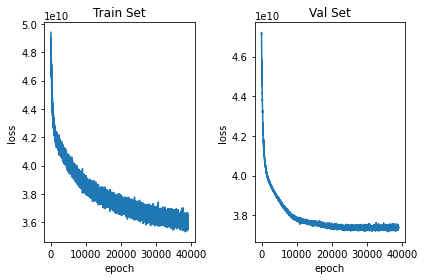

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 138033.11
	Invalid MEFs,MDFs = 1,0
	R Squared = 0.8812
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 140452.99
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8796
best R Squared seen on epoch 36906: 0.8804
best R Squared with no invalids predicted in train/val seen on epoch 36906: 0.8804
Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l1 at 0x7f4011f3f710>, MEF_reg_weight=100000000.0, MDF_reg_weight=100000000.0


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=8.480e+13, R Squared=-0.0011, Invalid MEFs=9185, Invalid MDFs=9726
	Val Set: Loss=2.302e+13, R Squared=-0.0002, Invalid MEFs=3126, Invalid MDFs=813
[Epoch 1000]
	Train Set: Loss=3.625e+11, R Squared=0.0569, Invalid MEFs=10, Invalid MDFs=4
	Val Set: Loss=2.937e+11, R Squared=0.0549, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=1.946e+11, R Squared=0.3598, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=1.984e+11, R Squared=0.3617, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=8.893e+10, R Squared=0.7074, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=8.730e+10, R Squared=0.7191, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=5.401e+10, R Squared=0.8223, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=5.125e+10, R Squared=0.8351, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.507e+10, R Squared=0.8517, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.247e+10, R Squared=0.8633, Invalid MEFs=0, Invalid MDFs=0

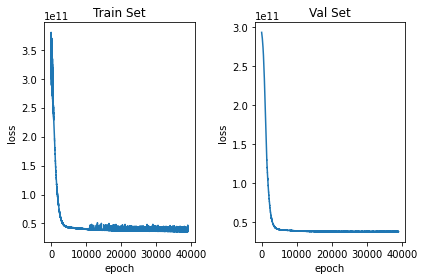

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 138983.90
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8793
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 141378.34
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8780
best R Squared seen on epoch 33033: 0.8787
best R Squared with no invalids predicted in train/val seen on epoch 33033: 0.8787
Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l1 at 0x7f4011f3f710>, MEF_reg_weight=10000000000.0, MDF_reg_weight=10000000000.0


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=4.578e+15, R Squared=0.0009, Invalid MEFs=3248, Invalid MDFs=10170
	Val Set: Loss=1.202e+15, R Squared=-0.0000, Invalid MEFs=170, Invalid MDFs=4676
[Epoch 1000]
	Train Set: Loss=5.332e+11, R Squared=0.0112, Invalid MEFs=0, Invalid MDFs=1
	Val Set: Loss=3.075e+11, R Squared=0.0104, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=3.001e+11, R Squared=0.0125, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.071e+11, R Squared=0.0116, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=2.995e+11, R Squared=0.0146, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.064e+11, R Squared=0.0139, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=2.984e+11, R Squared=0.0183, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.053e+11, R Squared=0.0176, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=2.964e+11, R Squared=0.0247, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.033e+11, R Squared=0.0239, Invalid MEFs=0, Invalid MDFs=0


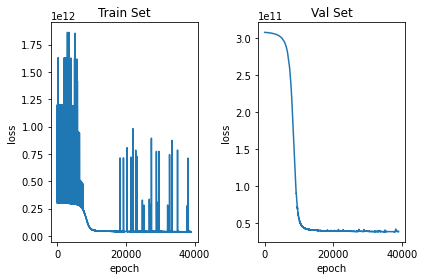

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 142605.42
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8725
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 141977.66
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8771
best R Squared seen on epoch 39094: 0.8783
best R Squared with no invalids predicted in train/val seen on epoch 39094: 0.8783
Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l2 at 0x7f400a28ff80>, MEF_reg_weight=10000.0, MDF_reg_weight=10000.0


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=6.905e+11, R Squared=0.0001, Invalid MEFs=7814, Invalid MDFs=7663
	Val Set: Loss=4.384e+11, R Squared=0.0003, Invalid MEFs=2822, Invalid MDFs=564
[Epoch 1000]
	Train Set: Loss=4.776e+10, R Squared=0.8428, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.607e+10, R Squared=0.8517, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.253e+10, R Squared=0.8601, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.089e+10, R Squared=0.8684, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.152e+10, R Squared=0.8634, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.994e+10, R Squared=0.8715, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=4.123e+10, R Squared=0.8644, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.950e+10, R Squared=0.8729, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.054e+10, R Squared=0.8666, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.918e+10, R Squared=0.8739, Invalid MEFs=0, Invalid MDFs=0
[E

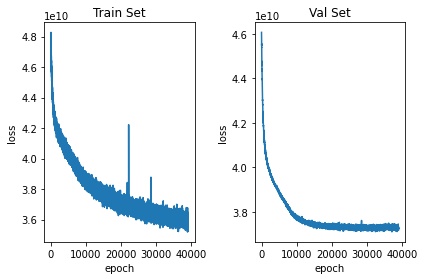

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 137589.44
	Invalid MEFs,MDFs = 2,4
	R Squared = 0.8822
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 140262.55
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8800
best R Squared seen on epoch 38122: 0.8806
best R Squared with no invalids predicted in train/val seen on epoch 38122: 0.8806
Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l2 at 0x7f400a28ff80>, MEF_reg_weight=1000000.0, MDF_reg_weight=1000000.0


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=2.625e+13, R Squared=-0.0000, Invalid MEFs=4719, Invalid MDFs=9448
	Val Set: Loss=2.755e+12, R Squared=-0.0001, Invalid MEFs=0, Invalid MDFs=4543
[Epoch 1000]
	Train Set: Loss=4.840e+10, R Squared=0.8407, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.627e+10, R Squared=0.8511, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.259e+10, R Squared=0.8599, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.080e+10, R Squared=0.8687, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.182e+10, R Squared=0.8624, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.985e+10, R Squared=0.8717, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=4.115e+10, R Squared=0.8646, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.948e+10, R Squared=0.8729, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.102e+10, R Squared=0.8650, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.913e+10, R Squared=0.8741, Invalid MEFs=0, Invalid MDFs=0
[E

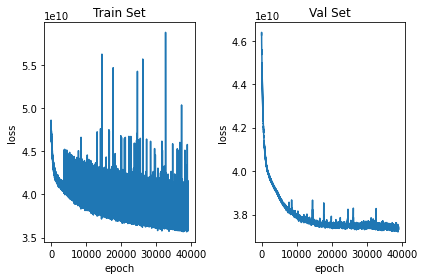

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 137733.82
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8814
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 140601.89
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8796
best R Squared seen on epoch 39885: 0.8803
best R Squared with no invalids predicted in train/val seen on epoch 39885: 0.8803
Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l2 at 0x7f400a28ff80>, MEF_reg_weight=100000000.0, MDF_reg_weight=100000000.0


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=4.524e+15, R Squared=-0.0015, Invalid MEFs=8711, Invalid MDFs=12492
	Val Set: Loss=8.588e+14, R Squared=-0.0006, Invalid MEFs=1302, Invalid MDFs=5260
[Epoch 1000]
	Train Set: Loss=1.437e+13, R Squared=0.0416, Invalid MEFs=26, Invalid MDFs=48
	Val Set: Loss=2.986e+11, R Squared=0.0392, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=3.381e+11, R Squared=0.2417, Invalid MEFs=0, Invalid MDFs=2
	Val Set: Loss=2.367e+11, R Squared=0.2382, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=8.855e+10, R Squared=0.7086, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=8.811e+10, R Squared=0.7164, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=5.217e+10, R Squared=0.8283, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.860e+10, R Squared=0.8436, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.530e+10, R Squared=0.8509, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.213e+10, R Squared=0.8644, Invalid MEFs=0, Invalid MDF

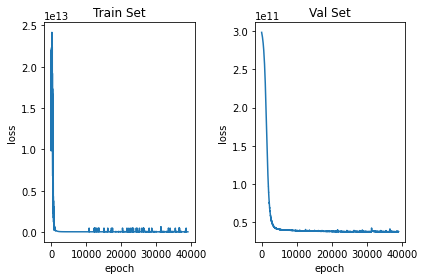

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 139359.91
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8785
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 141164.51
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8784
best R Squared seen on epoch 37460: 0.8792
best R Squared with no invalids predicted in train/val seen on epoch 37460: 0.8792
Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l2 at 0x7f400a28ff80>, MEF_reg_weight=10000000000.0, MDF_reg_weight=10000000000.0


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=5.301e+17, R Squared=-0.0006, Invalid MEFs=11057, Invalid MDFs=7674
	Val Set: Loss=2.343e+17, R Squared=-0.0002, Invalid MEFs=5258, Invalid MDFs=354
[Epoch 1000]
	Train Set: Loss=5.681e+12, R Squared=0.0090, Invalid MEFs=0, Invalid MDFs=1
	Val Set: Loss=3.083e+11, R Squared=0.0080, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=9.946e+13, R Squared=0.0098, Invalid MEFs=2, Invalid MDFs=2
	Val Set: Loss=3.080e+11, R Squared=0.0089, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.005e+11, R Squared=0.0113, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.075e+11, R Squared=0.0104, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=2.997e+11, R Squared=0.0139, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.067e+11, R Squared=0.0130, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=5.678e+12, R Squared=0.0187, Invalid MEFs=0, Invalid MDFs=1
	Val Set: Loss=3.053e+11, R Squared=0.0177, Invalid MEFs=0, Invalid MDFs=0

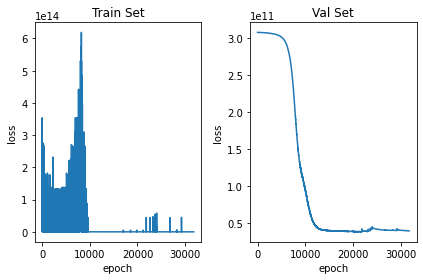

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 148290.97
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8616
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 144354.27
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8721
best R Squared seen on epoch 22795: 0.8761
best R Squared with no invalids predicted in train/val seen on epoch 22795: 0.8761


In [20]:
hidden_dim_settings = [[512,256]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [0.5]
regularization_weights = [[1e6,1e6],[1e8,1e8],[1e10,1e10]]
loss_function = mse_loss_regularized_preds_l1
save_prefix = "l1_output_reg"

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
              for reg_weights in regularization_weights:
                  train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data, loss_function, *reg_weights, save_prefix, epochs=40000)


regularization_weights = [[1e4,1e4],[1e6,1e6],[1e8,1e8],[1e10,1e10]]
loss_function = mse_loss_regularized_preds_l2
save_prefix = "l2_output_reg"

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
              for reg_weights in regularization_weights:
                  train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data, loss_function, *reg_weights, save_prefix, epochs=40000)

Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l1 at 0x7f4011f3f710>, MEF_reg_weight=0, MDF_reg_weight=0


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=3.043e+11, R Squared=-0.0011, Invalid MEFs=10836, Invalid MDFs=9966
	Val Set: Loss=3.109e+11, R Squared=-0.0005, Invalid MEFs=5223, Invalid MDFs=3514
[Epoch 1000]
	Train Set: Loss=4.846e+10, R Squared=0.8406, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.609e+10, R Squared=0.8517, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.265e+10, R Squared=0.8597, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.083e+10, R Squared=0.8686, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.140e+10, R Squared=0.8638, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.979e+10, R Squared=0.8720, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=4.080e+10, R Squared=0.8658, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.937e+10, R Squared=0.8733, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.045e+10, R Squared=0.8669, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.905e+10, R Squared=0.8743, Invalid MEFs=0, Invalid MDFs=

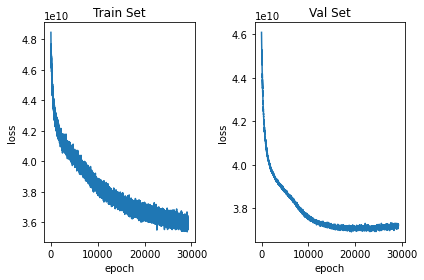

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 138208.44
	Invalid MEFs,MDFs = 105,140
	R Squared = 0.8812
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 140309.48
	Invalid MEFs,MDFs = 20,32
	R Squared = 0.8802
best R Squared seen on epoch 20216: 0.8812
best R Squared with no invalids predicted in train/val seen on epoch 7785: 0.8768


In [21]:
hidden_dim_settings = [[512,256]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [0.5]
regularization_weights = [[0,0]]
loss_function = mse_loss_regularized_preds_l1
save_prefix = "no_output_reg"

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
              for reg_weights in regularization_weights:
                  train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data, loss_function, *reg_weights, save_prefix, epochs=40000)

### Train with big model, regularization, and bias term

Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5, loss_function=<function mse_loss_regularized_preds_l2 at 0x7fb95ac569e0>, MEF_reg_weight=10000.0, MDF_reg_weight=10000.0, bias=True


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=7.937e+11, R Squared=-0.0008, Invalid MEFs=10015, Invalid MDFs=8711
	Val Set: Loss=5.601e+11, R Squared=-0.0006, Invalid MEFs=5216, Invalid MDFs=3451
[Epoch 1000]
	Train Set: Loss=4.792e+10, R Squared=0.8423, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.633e+10, R Squared=0.8509, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.270e+10, R Squared=0.8595, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.083e+10, R Squared=0.8686, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.168e+10, R Squared=0.8628, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.988e+10, R Squared=0.8717, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=4.100e+10, R Squared=0.8651, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.942e+10, R Squared=0.8732, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.043e+10, R Squared=0.8670, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.905e+10, R Squared=0.8743, Invalid MEFs=0, Invalid MDFs=

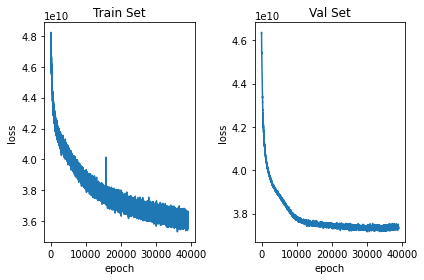

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 137286.72
	Invalid MEFs,MDFs = 4,1
	R Squared = 0.8823
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 140281.42
	Invalid MEFs,MDFs = 0,0
	R Squared = 0.8798
best R Squared seen on epoch 31070: 0.8804
best R Squared with no invalids predicted in train/val seen on epoch 31070: 0.8804


In [37]:
hidden_dim_settings = [[512,256]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [0.5]
bias_term = True

# regularization_weights = [[1e6,1e6]]#,[1e8,1e8],[1e10,1e10]]
# loss_function = mse_loss_regularized_preds_l1
# save_prefix = "l1_output_reg_and_bias"

# for hidden_dims in hidden_dim_settings:
#     for lr in lrs:
#         for weight_decay in weight_decays:
#             for dropout_p in dropout_probs:
#               for reg_weights in regularization_weights:
#                   train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data,
#                                           loss_function, *reg_weights, bias_term, save_prefix, epochs=40000)


regularization_weights = [[1e4,1e4]]#,[1e6,1e6],[1e8,1e8],[1e10,1e10]]
loss_function = mse_loss_regularized_preds_l2
save_prefix = "l2_output_reg_and_bias"

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
              for reg_weights in regularization_weights:
                  train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data,
                                          loss_function, *reg_weights, bias_term, save_prefix, epochs=40000)

### trying different architectures / params / features

In [ ]:
## leveled off at .8 train and .845 val after about 20k epochs (10 mins)...
## it is possible LR is too high here or dropout is regularizing too much...
## higher val could be because my train is reported with model in training mode so dropout is affected.
# hidden_dim_settings = [[32,16,8,8]]
# lrs = [.0003]
# weight_decays = [.01]
# dropout_probs = [.3]


## gets ~.87 at 15000 epochs (~2mins)
# hidden_dim_settings = [[16,8]]
# lrs = [.001]
# weight_decays = [.01]
# dropout_probs = [0.0]

# gets  at  epochs (~mins)
hidden_dim_settings = [[8,8],[8,8,8],[8,8,8,8],[16,8,8],[32,16],]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [0.0]



for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
                train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data)


Model Params: hidden_dims=8,8, learning_rate=0.001, weight_decay=0.01, dropout=0.0


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# sticking with 2 layers seems to give smoother optimization on the validation set... (?)
# this is with Is_Weekend set of features
hidden_dim_settings = [[32,16],[16,16]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [0.0,0.2]



for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
                train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data)


In [ ]:
# This is with the one-hot-encoded day of week feature
hidden_dim_settings = [[32,16],[16,16]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [0.0,0.1]

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
                train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data)

In [ ]:
# This is without a day of week feature (so most similar to the original feature set since that actually didn't either)
hidden_dim_settings = [[32,16],[16,16]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [0.0,0.1]

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
                train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data)

32,16 with no dropout on the no-day-of-week feature set seems like it does the best, though need early stopping / save best model.

Just for kicks let's try a bigger model with higher dropout. Should take a lot longer to train which is why I've avoided exploring this more, but let's try here...

In [ ]:
# This is without a day of week feature (so most similar to the original feature set since that actually didn't either)
hidden_dim_settings = [[256,128]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [.4]

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
                train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data)

In [ ]:
# This is without a day of week feature (so most similar to the original feature set since that actually didn't either)
hidden_dim_settings = [[256,128],[128,128]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [.5]

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
                train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data)

Improvement with the bigger model doesn't seem that noticeable, so I'll go with the smaller model

In [ ]:
# This is without a day of week feature (so most similar to the original feature set since that actually didn't either)
hidden_dims = [32,16]
lr = .001
weight_decay = .01
dropout_p = 0.0

best_model_path = train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data)

In [ ]:
best_model_path

In [ ]:
# This is without a day of week feature (so most similar to the original feature set since that actually didn't either)
hidden_dims = [256,128]
lr = .001
weight_decay = .01
dropout_p = 0.5

best_model_path_256 = train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data)

hidden_dims = [128,128]
lr = .001
weight_decay = .01
dropout_p = 0.4

best_model_path_128 = train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data)

### Try again dropping temp features

Model Params: hidden_dims=256,128, learning_rate=0.001, weight_decay=0.01, dropout=0.5


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0] Train Set: Loss=3.033e+11, R Squared=0.0019	Val Set: Loss=3.108e+11, R Squared=-0.0001
[Epoch 1000] Train Set: Loss=6.064e+10, R Squared=0.8005	Val Set: Loss=5.752e+10, R Squared=0.8149
[Epoch 2000] Train Set: Loss=4.630e+10, R Squared=0.8477	Val Set: Loss=4.314e+10, R Squared=0.8612
[Epoch 3000] Train Set: Loss=4.433e+10, R Squared=0.8541	Val Set: Loss=4.128e+10, R Squared=0.8672
[Epoch 4000] Train Set: Loss=4.382e+10, R Squared=0.8558	Val Set: Loss=4.079e+10, R Squared=0.8687
[Epoch 5000] Train Set: Loss=4.373e+10, R Squared=0.8561	Val Set: Loss=4.034e+10, R Squared=0.8702
[Epoch 6000] Train Set: Loss=4.321e+10, R Squared=0.8578	Val Set: Loss=4.009e+10, R Squared=0.8710
[Epoch 7000] Train Set: Loss=4.301e+10, R Squared=0.8585	Val Set: Loss=3.983e+10, R Squared=0.8718
[Epoch 8000] Train Set: Loss=4.275e+10, R Squared=0.8593	Val Set: Loss=3.961e+10, R Squared=0.8725
[Epoch 9000] Train Set: Loss=4.269e+10, R Squared=0.8595	Val Set: Loss=3.937e+10, R Squared=0.8733
[Epoch 10000

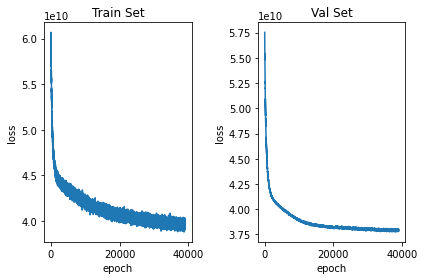

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 144398.24
	R Squared = 0.8683
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 141643.47
	R Squared = 0.8780
best R Squared seen on epoch 39202: 0.8785
Model Params: hidden_dims=128,128, learning_rate=0.001, weight_decay=0.01, dropout=0.5


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0] Train Set: Loss=3.036e+11, R Squared=0.0011	Val Set: Loss=3.107e+11, R Squared=0.0001
[Epoch 1000] Train Set: Loss=6.059e+10, R Squared=0.8006	Val Set: Loss=5.887e+10, R Squared=0.8106
[Epoch 2000] Train Set: Loss=4.739e+10, R Squared=0.8441	Val Set: Loss=4.410e+10, R Squared=0.8581
[Epoch 3000] Train Set: Loss=4.540e+10, R Squared=0.8506	Val Set: Loss=4.208e+10, R Squared=0.8646
[Epoch 4000] Train Set: Loss=4.535e+10, R Squared=0.8508	Val Set: Loss=4.145e+10, R Squared=0.8666
[Epoch 5000] Train Set: Loss=4.459e+10, R Squared=0.8533	Val Set: Loss=4.120e+10, R Squared=0.8674
[Epoch 6000] Train Set: Loss=4.419e+10, R Squared=0.8546	Val Set: Loss=4.105e+10, R Squared=0.8679
[Epoch 7000] Train Set: Loss=4.425e+10, R Squared=0.8544	Val Set: Loss=4.082e+10, R Squared=0.8686
[Epoch 8000] Train Set: Loss=4.408e+10, R Squared=0.8549	Val Set: Loss=4.067e+10, R Squared=0.8691
[Epoch 9000] Train Set: Loss=4.369e+10, R Squared=0.8562	Val Set: Loss=4.043e+10, R Squared=0.8699
[Epoch 10000]

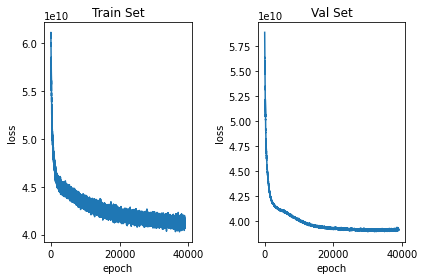

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 146267.13
	R Squared = 0.8640
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 143898.41
	R Squared = 0.8741
best R Squared seen on epoch 31050: 0.8748
Model Params: hidden_dims=512,256, learning_rate=0.001, weight_decay=0.01, dropout=0.5


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0] Train Set: Loss=3.038e+11, R Squared=0.0004	Val Set: Loss=3.107e+11, R Squared=0.0002
[Epoch 1000] Train Set: Loss=4.773e+10, R Squared=0.8430	Val Set: Loss=4.596e+10, R Squared=0.8521
[Epoch 2000] Train Set: Loss=4.246e+10, R Squared=0.8603	Val Set: Loss=4.088e+10, R Squared=0.8685
[Epoch 3000] Train Set: Loss=4.162e+10, R Squared=0.8630	Val Set: Loss=3.982e+10, R Squared=0.8719
[Epoch 4000] Train Set: Loss=4.100e+10, R Squared=0.8651	Val Set: Loss=3.940e+10, R Squared=0.8732
[Epoch 5000] Train Set: Loss=4.056e+10, R Squared=0.8665	Val Set: Loss=3.914e+10, R Squared=0.8740
[Epoch 6000] Train Set: Loss=4.026e+10, R Squared=0.8675	Val Set: Loss=3.889e+10, R Squared=0.8748
[Epoch 7000] Train Set: Loss=3.997e+10, R Squared=0.8685	Val Set: Loss=3.857e+10, R Squared=0.8759
[Epoch 8000] Train Set: Loss=3.982e+10, R Squared=0.8690	Val Set: Loss=3.837e+10, R Squared=0.8765
[Epoch 9000] Train Set: Loss=3.884e+10, R Squared=0.8722	Val Set: Loss=3.802e+10, R Squared=0.8777
[Epoch 10000]

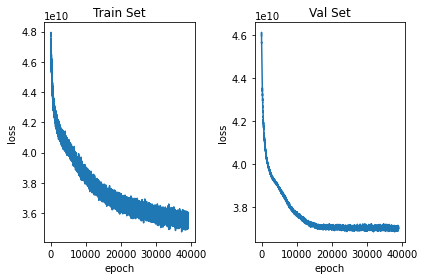

Train Set:
	Mean Emissions Change = 411703.26
	Mean Error = 137254.37
	R Squared = 0.8831
Val Set:
	Mean Emissions Change = 417399.67
	Mean Error = 139966.61
	R Squared = 0.8810
best R Squared seen on epoch 32847: 0.8814


In [ ]:
#ooooh, now without noisy temp features, increasing expressiveness is helping...
hidden_dim_settings = [[256,128],[128,128],[512,256]]
lrs = [.001]
weight_decays = [.01]
dropout_probs = [.5]

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
                train_model_with_params(hidden_dims, lr, weight_decay, dropout_p, CAISO_Data, "no_temp_features", epochs=40000)

## Inference on all data

In [49]:
## best model with no invalids on train/val and no bias
# best_model_dir = "drive/MyDrive/NN_MEFs/FF_models/l2_output_reg/hidden=512,256,LR=0.001,w_decay=0.01,dropout=0.5,MEF_reg=10000.0,MDF_reg=10000.0"
# model_file = "epoch=38122,r2=0.8806,Invalids=0.pth"
# best_model_path = f"{best_model_dir}/{model_file}"

# best model with no invalids on train/val with bias
best_model_dir = "drive/MyDrive/NN_MEFs/FF_models/l1_output_reg_and_bias/hidden=512,256,LR=0.001,w_decay=0.01,dropout=0.5,MEF_reg=1000000.0,MDF_reg=1000000.0,bias=True"
model_file = "epoch=36772,r2=0.8805,Invalids=0.pth"
best_model_path = f"{best_model_dir}/{model_file}"



In [60]:
hidden_dims = [512,256]
bias_term = True
dropout_p = 0.5


model = get_model(n_input, hidden_dims, n_out, dropout_p)
model.to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

train_pred_coeff = model(train_x.float()).cpu()
val_pred_coeff = model(val_x.float()).cpu()
test_pred_coeff = model(test_x.float()).cpu()

print("R Squared:")
print(f"\tTrain: {get_r_squared(train_pred_coeff, CAISO_train, bias_term):.4f}")
print(f"\tVal: {get_r_squared(val_pred_coeff, CAISO_val, bias_term):.4f}")
print(f"\tTest: {get_r_squared(test_pred_coeff, CAISO_test, bias_term):.4f}")
print("Mean Absolute Error:")
print(f"\tTrain: {get_mean_abs_err(train_pred_coeff, CAISO_train, bias_term):.2f}")
print(f"\tVal: {get_mean_abs_err(val_pred_coeff, CAISO_val, bias_term):.2f}")
print(f"\tTest: {get_mean_abs_err(test_pred_coeff, CAISO_test, bias_term):.2f}")
print("Count Invalid Values Predicted:")
invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
invalid_test_MEFs, invalid_test_MDFs = get_count_invalid_preds(test_pred_coeff)
print(f"\tTrain: Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
print(f"\tVal: Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")
print(f"\tTest: Invalid MEFs={invalid_test_MEFs}, Invalid MDFs={invalid_test_MDFs}")


R Squared:
	Train: 0.8921
	Val: 0.8805
	Test: 0.8755
Mean Absolute Error:
	Train: 131028.76
	Val: 140016.71
	Test: 139890.26
Count Invalid Values Predicted:
	Train: Invalid MEFs=0, Invalid MDFs=0
	Val: Invalid MEFs=0, Invalid MDFs=0
	Test: Invalid MEFs=0, Invalid MDFs=0


### Put the MEFs and MDFs from all sets back together and in order into the original DF for viewing

In [51]:
all_preds_w_timestamps = list(zip(CAISO_val.index, val_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_train.index, train_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_test.index, test_pred_coeff.detach().numpy()))
all_preds_w_timestamps.sort(key=lambda pair: pair[0])
all_preds_ordered = np.array([pair[1] for pair in all_preds_w_timestamps])

In [52]:
all_preds_ordered

array([[ 370.72943, -350.03064, 6396.022  ],
       [ 345.05103, -323.2915 , 6071.847  ],
       [ 323.41635, -301.2585 , 5678.251  ],
       ...,
       [ 185.47028, -178.93307, 1364.1282 ],
       [ 174.08382, -188.8942 , 1355.093  ],
       [ 202.60051, -229.76308, 1624.3225 ]], dtype=float32)

In [53]:
all_MEFs_ordered = all_preds_ordered[:,0]
all_MDFs_ordered = all_preds_ordered[:,1]
all_intercepts_ordered = all_preds_ordered[:,2]

In [62]:
CAISO_Data.loc[:,"MEF"] = all_MEFs_ordered
CAISO_Data.loc[:,"MDF"] = all_MDFs_ordered
if bias_term:
    CAISO_Data.loc[:,"Intercept"] = all_intercepts_ordered

#calculate some error stuff. rn i am thinking R2 is the best measure of error
d_emissions = CAISO_Data.loc[:,'MEF'] * CAISO_Data.loc[:,'delta_Load'] \
            + CAISO_Data.loc[:,'MDF'] * CAISO_Data.loc[:,'delta_VRE']
if bias_term:
    d_emissions += CAISO_Data.loc[:,"Intercept"]
CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
CAISO_Data.loc[:,'Error']=CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
CAISO_Data.loc[:,'%_Error']=np.abs(CAISO_Data.loc[:,'Error'])/np.abs(CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
print("Whole Data Set:")
print(f"\tMean Emissions Change = {np.mean(np.abs(CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
print(f"\tR Squared = {r2_score(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
print(f"\tMean Absolute Error = {mean_absolute_error(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.2f}")

Whole Data Set:
	Mean Emissions Change = 413165.73
	R Squared = 0.8864
	Mean Absolute Error = 134598.78


In [63]:
CAISO_Data.head()

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,...,Day_of_Week=3,Day_of_Week=4,Day_of_Week=5,Day_of_Week=6,MEF,MDF,Intercept,Predicted_delta_Total_CO2_Emissions,Error,%_Error
2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,-24.142180,...,False,False,False,False,370.729431,-350.030640,6396.021973,-459526.000872,-122496.206729,0.363458
2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,-21.594332,...,False,False,False,False,345.051025,-323.291504,6071.847168,-304454.710093,-61432.876394,0.252787
2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,-20.952957,...,False,False,False,False,323.416351,-301.258514,5678.250977,-172189.482236,-27342.684733,0.188770
2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,-2.164379,...,False,False,False,False,305.443024,-282.996887,5341.076660,-55190.639304,-30414.069545,1.227534
2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,69.703951,...,False,False,False,False,303.949066,-272.057770,5023.662109,26216.649928,-23037.486613,0.467727


In [64]:
CAISO_Data.to_csv(f"{best_model_dir}/CAISO_Data_2019_2021_NN_Ts.with_coeff_preds.csv")

In [65]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val <=0])

0

In [66]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val >600])

53

In [67]:
CAISO_Data.loc[:,"MEF"].max()

719.43835